In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from timeit import default_timer as timer
import warnings
warnings.filterwarnings('ignore')

### Getting mock data for testing

In [2]:
df = pd.read_csv('/home/astroguy/Desktop/research/research_emannuele/init_coh_search_algthm/sim_pulse_01.txt', delimiter = '    ')
df.tail(2)

,time_sec,intensity
16382,59.996338,0.934082
16383,60.000000,-0.914551


### Constant acceleration model eqn (1)

In [3]:
rest_phase = np.arange(0, (np.pi*37)/18, (np.pi)/18)     # rest phase phi_0 in eqn below values taken from 
                                                    # (0 to 2pi) with an interval of pi/4
time = np.array(df['time_sec'])
freq = np.linspace(1,10, 2048)                            # frequency omega_0 taken from (0 to 12)Hz at an interval 
                                                    # of 1.5Hz
acceleration = 0                                    # acceleration parameter alpha in the eqn below
print('Number of phase trials:', len(rest_phase))
print('Number of frequency trials:', len(freq))

Number of phase trials: 37
Number of frequency trials: 2048


Equation 1 in K smith(2016). 
$$ \phi(t) = \phi_{0} + \omega_{0}t + \frac{1}{2}\alpha t^2$$

In [4]:
def pulse_phase(p0,t,w0,a):
    '''
    This function calculates and returns pulse phase at any given time 't' when acceleration 'a', intial 
    phase 'p0' and angular frequency 'w0' is known.
    '''
    phase = p0 + w0*t + 0.5*a*t**2
    return phase



### Von-Mises profile eqn (2)

Von Mises profile can be obtained from the euqtion(Eqn 2, K Smith)

$$ \rho(\phi) = e^{-2\kappa(sin^2(\phi/2))}$$

where $$\kappa = \frac{log(2)}{2sin^2{(\pi D/2)}}$$

In [5]:
def von_mises_profile(phase_angle,duty):
    '''
    This function calculates von_mises profile based on duty cycle obtained from previous kappa function.
    For the vlue of pulse_phase it makes a call from pulse_phase function defined above
    '''
    k = (np.log(2))/(2*(np.sin((np.pi*duty)/2))**2)
    
    y = np.exp(-2*k*(np.sin(phase_angle/2))**2)
    
    return y

### Detection statistic (5)

Intensity time stream $I(t) = \rho(\phi(t))$. So, ignoring the downsampling for now, we just take intensity time stream to be values calculated from von-mises funtion above. But we use normalization condition to find '$\eta$' (noize parameter) using the equation(eqn 4 in Smith K) below.

$$ \eta^{-2} t_{s} \sum_{k=0}^{N-1} (I_{k})^2 = 1$$ 

So rearranging we get,

\begin{equation}
 \eta^{-2} = \frac{1}{t_{s} \sum_{k=0}^{N-1}(I_{k})^2} 
\end{equation}

We can use this to find the detection statistic using equation below. 

$$ \hat{\epsilon} = \eta^{-2} t_{s} \sum_{k=0}^{N-1} d_{k}I_{k} $$

In [6]:
def detection_statistic(sampletime, datastream, phaseangle):
    '''
    This function calculates the detection statistic (eqn 5, K smith). Function arguments dk and ik are data 
    timestream and intensity timestream that we suuply as lists. d_k is intensity data in the table above and 
    I_k is von_mises profile calculated for various phase angles. Phase angle itself is calculated from pulse_
    phase function for the time series. This furnction returns detection statistic value as an output.
    '''
    dk = np.array(datastream)
    I_k = np.array(von_mises_profile(phaseangle,0.1))
    eta_neg_sqr = 1/(sampletime*(np.sum(I_k**2)))
    
    det_stat = eta_neg_sqr*sampletime*(np.sum(dk*I_k))

    return det_stat


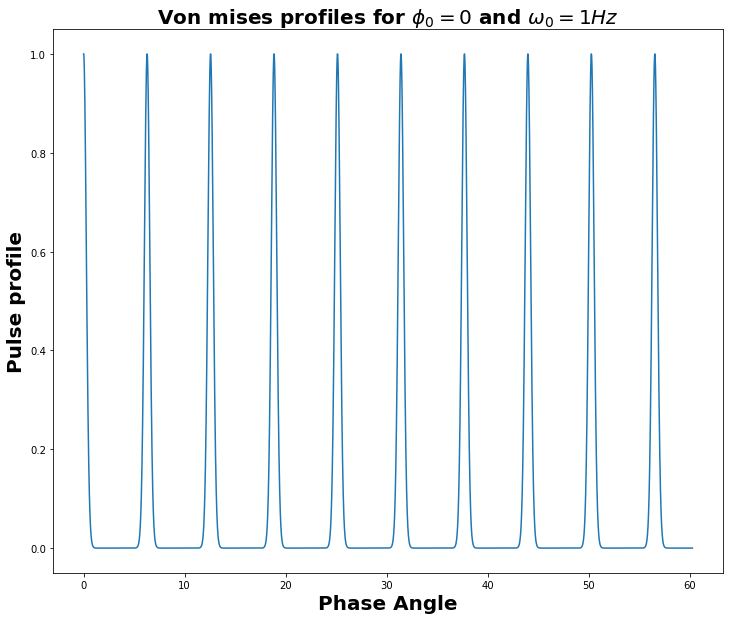


 This codeblock took 1.1012660352000239 minutes to run.

 Detection statistic data frame with corresponding phase and frequency


,Phase,Frequency,Detection Statistic
0,0.0,1.000000,0.456982
1,0.0,1.004397,0.467544


In [8]:
# These two lists will store the (phase, freq) values and calculated phase. First list of (phase,freq) might 
# later be useful to match detection statistic to corresponding phase/freq.

start_time = timer()

phase_list = []
freq_list = []
det_stat_list = []

# This nested loop will calculate phase for each combination of (phase,freq). 

for ind1 in np.arange(len(rest_phase)):
    p0_val = rest_phase[ind1]
    for ind2 in np.arange(len(freq)):
        freq_value = freq[ind2]
        phase_list.append(rest_phase[ind1])
        freq_list.append(freq[ind2])
        phase_val = np.array(pulse_phase(p0_val, time, freq_value, acceleration))
        det_stat_val = detection_statistic(0.005, np.array(df['intensity']),  phase_val)
        det_stat_list.append(det_stat_val)
        if (ind1 == 0) and (ind2 == 1):
            fig, pulseprofile = plt.subplots(figsize = (12,10))
            pulseprofile.plot(phase_val, von_mises_profile(phase_val, 0.1))
            pulseprofile.set_xlabel('Phase Angle', fontsize = 20, weight = 'bold')
            pulseprofile.set_ylabel('Pulse profile', fontsize = 20, weight = 'bold')
            pulseprofile.set_title('Von mises profiles for $\phi_{0} = 0$ and $\omega_{0} = 1Hz$',fontsize = 20, weight = 'bold')
            plt.show()

data = {'Phase': phase_list, 'Frequency': freq_list, 'Detection Statistic': det_stat_list}
phasefreqdf = pd.DataFrame(data, index = np.arange(len(det_stat_list)))
end_time = timer()

total_time = (end_time -start_time)/60
print(f'\n This codeblock took {total_time} minutes to run.')
print('\n Detection statistic data frame with corresponding phase and frequency')
phasefreqdf.head(2) 

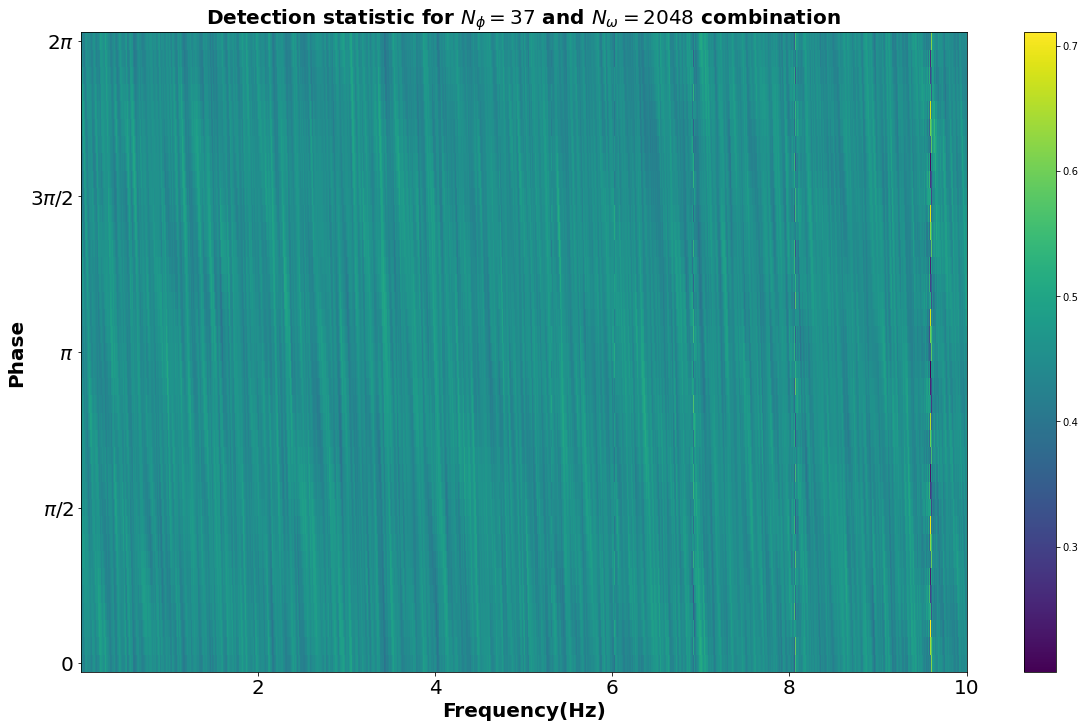

In [9]:
fig , phasefreqmap = plt.subplots(figsize = (15,10), layout = 'constrained')
X = np.linspace(0.00219834, 10.00219834, 2049)
Y = np.linspace(-0.08726, 6.37044, 38)
Z = np.array(phasefreqdf['Detection Statistic']).reshape(37,2048)
pcm = phasefreqmap.pcolormesh(X, Y, Z, vmin=Z.min(), vmax=Z.max())
phasefreqmap.set_xlabel('Frequency(Hz)', fontweight = 'bold', fontsize = 20)
phasefreqmap.set_ylabel('Phase', fontweight = 'bold', fontsize = 20)
yaxis_tickmarks = [0, '$\pi/2$', '$\pi$',  '$3\pi/2$', '$2\pi$']
phasefreqmap.set_yticks(ticks = [0, 1.57079633, 3.14159265, 4.71238898, 6.2831853], labels = yaxis_tickmarks)
phasefreqmap.yaxis.set_tick_params(labelsize=20)
phasefreqmap.xaxis.set_tick_params(labelsize=20)
phasefreqmap.set_title('Detection statistic for $N_{\phi} = 37$ and $N_{\omega} = 2048$ combination', fontweight = 'bold', fontsize = 20)
fig.colorbar(pcm, ax = phasefreqmap)
# plt.savefig('/home/astroguy/Desktop/detection_stat_caseIII.pdf')  # Only if you want to save your figure. 
plt.show()